In [1]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

s = 126
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

pytorch version:  1.3.1
cuda available:  True


# Train Cifar10 on Resnet32

In [2]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

In [3]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


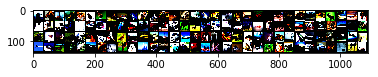

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True,
                                        download=True, transform=transform_train)

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
CIFAR10_train_dataset, CIFAR10_val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_train_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_val_loader = torch.utils.data.DataLoader(CIFAR10_val_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_test = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False,
                                       download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=BATCH_SIZE_TEST_CIFAR10,
                                         shuffle=False)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [5]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_test)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)

CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

train_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
test_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


# Train CIFAR10 on ResNet18

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


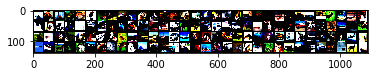

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def phi(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out
    
    def forward(self, x):
        out = self.phi(x)
        out = self.fc(out)
        return(out)


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR10_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [12]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [13]:
def test(net, epoch, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print("test loss: ", test_loss)
        print("test accuracy: ", correct/total)

In [14]:
def train_all():
    CIFAR10_path = 'weights/cifar10_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, trainloader, CIFAR10_path)
            test(CIFAR10_model, epoch, testloader)
            epoch += 1
        lr /= 10

In [15]:
train_all()

current learning rate:  0.1

Epoch: 0
train loss:  787.8048022985458
train accuracy:  0.29138
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  130.1247147321701
test accuracy:  0.3878

Epoch: 1
train loss:  604.6919292211533
train accuracy:  0.42902
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  114.41172480583191
test accuracy:  0.4638

Epoch: 2
train loss:  529.2565062046051
train accuracy:  0.50436
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  99.33933591842651
test accuracy:  0.5441

Epoch: 3
train loss:  440.69397270679474
train accuracy:  0.59708
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  85.9754581451416
test accuracy:  0.6116

Epoch: 4
train loss:  369.4627437591553
train accuracy:  0.66576
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  90.12607306241989
test accuracy:  0.6124

Epoch: 5
train loss:  308.3439773321152
train accuracy:  0.72194
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:

train loss:  130.760771676898
train accuracy:  0.8856
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  42.70304638147354
test accuracy:  0.8203

Epoch: 49
train loss:  129.09588414430618
train accuracy:  0.88894
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  38.20109987258911
test accuracy:  0.844

Epoch: 50
train loss:  129.41893269121647
train accuracy:  0.88742
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  37.517845779657364
test accuracy:  0.8477

Epoch: 51
train loss:  129.9248482733965
train accuracy:  0.8858
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  33.73064462840557
test accuracy:  0.86

Epoch: 52
train loss:  129.84284448623657
train accuracy:  0.88662
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  47.71906867623329
test accuracy:  0.7999

Epoch: 53
train loss:  126.89834266901016
train accuracy:  0.89076
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  57.42096948623657
test accuracy: 

test loss:  35.229883909225464
test accuracy:  0.8535

Epoch: 97
train loss:  120.1807487308979
train accuracy:  0.89562
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  41.69107377529144
test accuracy:  0.827

Epoch: 98
train loss:  120.14776457846165
train accuracy:  0.89784
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  39.91659200191498
test accuracy:  0.8403

Epoch: 99
train loss:  120.82390210032463
train accuracy:  0.89606
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  32.494914054870605
test accuracy:  0.8635
current learning rate:  0.01

Epoch: 100
train loss:  61.349334325641394
train accuracy:  0.94848
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  16.10549698024988
test accuracy:  0.93

Epoch: 101
train loss:  44.32848037406802
train accuracy:  0.96228
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  15.5003766939044
test accuracy:  0.9343

Epoch: 102
train loss:  37.16154409572482
train accuracy:  0.968

test loss:  22.466589733958244
test accuracy:  0.9243

Epoch: 145
train loss:  18.24958943389356
train accuracy:  0.9846
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  22.297752521932125
test accuracy:  0.9194

Epoch: 146
train loss:  18.947516387328506
train accuracy:  0.98366
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  20.402716904878616
test accuracy:  0.9276

Epoch: 147
train loss:  14.604930270463228
train accuracy:  0.98828
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  19.74571641534567
test accuracy:  0.9305

Epoch: 148
train loss:  17.88129129447043
train accuracy:  0.9849
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  20.26391365379095
test accuracy:  0.9286

Epoch: 149
train loss:  16.20090276747942
train accuracy:  0.98656
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  19.881090357899666
test accuracy:  0.9269
current learning rate:  0.001

Epoch: 150
train loss:  8.255671046674252
train accuracy:

test loss:  14.173613011837006
test accuracy:  0.9515

Epoch: 193
train loss:  0.9085032228613272
train accuracy:  0.9999
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  14.273177791386843
test accuracy:  0.9501

Epoch: 194
train loss:  0.8606634950265288
train accuracy:  0.9999
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  14.270782131701708
test accuracy:  0.9508

Epoch: 195
train loss:  0.7978313658386469
train accuracy:  0.99994
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  14.186302624642849
test accuracy:  0.9509

Epoch: 196
train loss:  0.8880569009343162
train accuracy:  0.99988
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  14.195976741611958
test accuracy:  0.9513

Epoch: 197
train loss:  0.8240347463870421
train accuracy:  0.99994
saving model at: weights/cifar10_resnet18_SGD.pth
test loss:  14.257228247821331
test accuracy:  0.9509

Epoch: 198
train loss:  0.8443641539197415
train accuracy:  0.99988
saving model a

In [16]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'weights/cifar10_resnet18_SGD.pth'
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0, testloader)

loading model from: weights/cifar10_resnet18_SGD.pth
test loss:  14.27922461181879
test accuracy:  0.9503


In [17]:
def Diag_second_order(model, train_loader, var0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    print("n: {} inputs to linear layer with m: {} classes".format(n, m))
    lossfunc = torch.nn.CrossEntropyLoss()

    tau = 1/var0

    extend(lossfunc, debug=False)
    extend(model.fc, debug=False)

    with backpack(DiagHessian()):

        max_len = len(train_loader)
        weights_cov = torch.zeros(max_len, m, n, device=device)
        biases_cov = torch.zeros(max_len, m, device=device)

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                W_ = W.diag_h
                b_ = b.diag_h

                #add_prior: since it will be flattened later we can just add the prior like that
                W_ += tau * torch.ones(W_.size(), device=device)
                b_ += tau * torch.ones(b_.size(), device=device)


            weights_cov[batch_idx] = W_
            biases_cov[batch_idx] = b_

            print("Batch: {}/{}".format(batch_idx, max_len))

        print(len(weights_cov))
        C_W = torch.mean(weights_cov, dim=0)
        C_b = torch.mean(biases_cov, dim=0)

    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        C_W_post = C_W
        C_b_post = C_b
        
    print("M_W_post size: ", M_W_post.size())
    print("M_b_post size: ", M_b_post.size())
    print("C_W_post size: ", C_W_post.size())
    print("C_b_post size: ", C_b_post.size())

    return(M_W_post, M_b_post, C_W_post, C_b_post)

In [18]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                               train_loader=trainloader,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68

In [19]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    #prob_correct = np.choose(targets, py_in.T).mean()
    prob_correct = py_in[targets].mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)

def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    if max(targets) > len(py_in[0]):
        targets = np.array(targets)
        targets[targets >= len(py_in[0])] = 0
    #prob_correct = np.choose(targets, py_out.T).mean()
    prob_correct = py_out[targets].mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

In [20]:
def get_Gaussian_output_old(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = len(mu_b)
    #print("batch_size, num_classes: ", batch_size, num_classes)
    mu_batch = torch.zeros(batch_size, num_classes)
    sigma_batch = torch.zeros(batch_size, num_classes, num_classes)
    for i in range(batch_size):
        per_class_sigmas = torch.zeros(num_classes)
        for j in range(num_classes):
            #create a diagonal Hessian
            hess = torch.diag(sigma_w[j])
            #b = x[i] @ hess @ x[i].t()
            #a = sigma_b[i]
            per_class_sigmas[j] = x[i] @ hess @ x[i].t() + sigma_b[j]

        #print("sizes: ", mu_w.size(), x[i].size(), mu_b.size())
        per_class_mus = x[i] @ mu_w + mu_b
        mu_batch[i] = per_class_mus
        sigma_batch[i] = torch.diag(per_class_sigmas)

    return(mu_batch, sigma_batch)

In [21]:
def get_Gaussian_output(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = mu_b.size(0)
    
    # get mu batch
    mu_w_batch = mu_w.repeat(batch_size, 1, 1)
    mu_b_batch = mu_b.repeat(batch_size, 1)
    mu_batch = torch.bmm(x.view(batch_size, 1, -1), mu_w_batch).view(batch_size, -1) + mu_b_batch
    
    #get sigma batch
    sigma_w_batch = sigma_w.repeat(batch_size, 1, 1)
    sigma_b_batch = sigma_b.repeat(batch_size, 1)
    sigmas_diag = torch.zeros(batch_size, num_classes, device='cuda')
    for j in range(num_classes):
        h1 = x * sigma_w_batch[:, j]
        helper = torch.matmul(h1.view(batch_size, 1, -1), x.view(batch_size, -1, 1))
        helper = helper.view(-1) + sigma_b_batch[:,j]
        sigmas_diag[:,j] = helper
        
    sigma_batch = torch.stack([torch.diag(x) for x in sigmas_diag])

    
    return(mu_batch, sigma_batch)


In [22]:
@torch.no_grad()
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, cuda=False, timing=False):
    py = []
    max_len = len(test_loader)
    if timing:
        time_sum = 0

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        #print("mu size: ", mu.size())
        #print("sigma size: ", Sigma.size())

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        t0 = time.time()
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)
        t1 = time.time()
        if timing:
            time_sum += (t1 - t0)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing: print("time used for sampling with {} samples: {}".format(n_samples, time_sum))
    
    return torch.cat(py, dim=0)

In [23]:
targets_CIFAR10 = testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in test_loader_SVHN:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

# MAP estimate

In [24]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, testloader, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [25]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [26]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.950; average entropy: 0.072;     MMC: 0.976; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.498;    MMC: 0.827; AUROC: 0.864; Prob @ correct: 0.100
[Out-MAP, KFAC, SVHN] Accuracy: 0.103; Average entropy: 0.637;    MMC: 0.784; AUROC: 0.917; Prob @ correct: 0.100


In [88]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.953, 0.952, 0.952, 0.950]
mmc_in = [0.979, 0.978, 0.979, 0.976]
mmc_out_CIFAR100 = [0.831, 0.827, 0.829, 0.827]
mmc_out_SVHN = [0.721, 0.809, 0.780, 0.784]

auroc_out_CIFAR100 = [0.872, 0.877, 0.874, 0.864]
auroc_out_SVHN = [0.939, 0.919, 0.927, 0.917]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.952 with std 0.001
MMC in: 0.978 with std 0.001
MMC out CIFAR100: 0.829 with std 0.002
MMC out SVHN: 0.774 with std 0.032
AUROC out CIFAR100: 0.872 with std 0.005
AUROC out SVHN: 0.925 with std 0.009


# Diagonal estimate

In [28]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 6.605843544006348
time used for sampling with 1000 samples: 6.474161148071289
time used for sampling with 1000 samples: 16.71169662475586


In [29]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [30]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.950; average entropy: 0.200;     MMC: 0.947; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.498;    MMC: 0.724; AUROC: 0.876; Prob @ correct: 0.100
[Out-Diag, KFAC, SVHN] Accuracy: 0.103; Average entropy: 0.979;    MMC: 0.672; AUROC: 0.921; Prob @ correct: 0.100


In [87]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [6.636955976486206, 6.716174125671387, 6.57476282119751, 6.605843544006348]
time_lpb_out_CIFAR100 = [6.614115238189697, 6.61441969871521, 6.560410737991333, 6.474161148071289]
time_lpb_out_SVHN = [17.011831521987915, 17.094997882843018, 17.031347036361694,16.71169662475586]

acc_in = [0.953, 0.952, 0.952, 0.950]
mmc_in = [0.950, 0.950, 0.950, 0.947]
mmc_out_CIFAR100 = [0.727, 0.721, 0.725, 0.724]
mmc_out_SVHN = [0.605, 0.685, 0.661, 0.672]

auroc_out_CIFAR100 = [0.884, 0.889, 0.885, 0.876]
auroc_out_SVHN = [0.943, 0.927, 0.933, 0.921]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 6.633 with std 0.053
Sampling Bridge time out CIFAR100: 6.566 with std 0.057
Sampling Bridge time out SVHN: 16.962 with std 0.148
accuracy: 0.952 with std 0.001
MMC in: 0.949 with std 0.001
MMC out CIFAR100: 0.724 with std 0.002
MMC out SVHN: 0.656 with std 0.031
AUROC out CIFAR100: 0.884 with std 0.005
AUROC out SVHN: 0.931 with std 0.008


# Dirichlet Laplace estimate

In [32]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [33]:
@torch.no_grad()
#U_post, V_post, B_post
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, verbose=False, cuda=False, timing=False):
    alphas = []
    if timing:
        time_sum = 0

    max_len = int(np.ceil(len(test_loader.dataset)/len(test_loader)))

    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        #mu_pred = phi @ M_W_post + M_b_post
        #mu_pred -= mu_pred.mean(1).view(-1,1)
        #Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        mu_pred, Cov_pred = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)
        
        t0 = time.time()
        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        t1 = time.time()
        if timing:
            time_sum += (t1-t0)

        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    if timing:
        print("total time used for transform: {:.05f}".format(time_sum))
    
    return(torch.cat(alphas, dim = 0))

In [34]:
CIFAR10_test_in_DIR_LPA = predict_DIR_LPA(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, verbose=False, timing=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()
CIFAR10_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01724
total time used for transform: 0.01580
total time used for transform: 0.04067


In [35]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_DIR_LPAn = CIFAR10_test_in_DIR_LPA/CIFAR10_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_DIR_LPAn = CIFAR10_test_out_CIFAR100_DIR_LPA/CIFAR10_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_DIR_LPAn = CIFAR10_test_out_SVHN_DIR_LPA/CIFAR10_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [36]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR10_test_in_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [37]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR10] Accuracy: 0.950; average entropy: 0.130;     MMC: 0.966; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.010; Average entropy: 0.762;    MMC: 0.771; AUROC: 0.852; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.103; Average entropy: 1.013;    MMC: 0.698; AUROC: 0.919; Prob @ correct: 0.100


In [86]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.01729, 0.01750, 0.01749,0.01724]
time_lpb_out_CIFAR100 = [0.01571,0.01601, 0.01570, 0.01580]
time_lpb_out_SVHN = [0.04075, 0.04107, 0.04046, 0.04067]


acc_in = [0.953, 0.952, 0.952, 0.950]
mmc_in = [0.971, 0.970, 0.970, 0.966]
mmc_out_CIFAR100 = [0.779, 0.774, 0.775, 0.771]
mmc_out_SVHN = [0.639, 0.747, 0.719, 0.698]


auroc_out_CIFAR100 = [0.856, 0.863, 0.859, 0.852]
auroc_out_SVHN = [0.935, 0.912, 0.923, 0.919]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.017 with std 0.000
Laplace Bridge time out CIFAR100: 0.016 with std 0.000
Laplace Bridge time out notmnist: 0.041 with std 0.000
accuracy: 0.952 with std 0.001
MMC in: 0.969 with std 0.002
MMC out CIFAR100: 0.775 with std 0.003
MMC out SVHN: 0.701 with std 0.040
AUROC out CIFAR100: 0.857 with std 0.004
AUROC out SVHN: 0.922 with std 0.008


In [39]:
from scipy.special import digamma, loggamma

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def log_beta_function(alpha):
    return(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha)))

def alphas_entropy(alphas):
    K = len(alphas[0])
    alphas = np.array(alphas)
    entropy = []
    for x in alphas:
        B = log_beta_function(x)
        alpha_0 = np.sum(x)
        C = (alpha_0 - K)*digamma(alpha_0)
        D = np.sum((x-1)*digamma(x))
        entropy.append(B + C - D)
    
    return(np.array(entropy))
        

def alphas_log_prob(alphas):
    alphas = np.array(alphas)
    dig_sum = digamma(alphas.sum(axis=1).reshape(-1,1))
    log_prob = digamma(alphas) - dig_sum
    return(log_prob)

def auroc_entropy(alphas_in, alphas_out):
    
    entropy_in = alphas_entropy(alphas_in)
    entropy_out = alphas_entropy(alphas_out)
    labels = np.zeros(len(entropy_in)+len(entropy_out), dtype='int32')
    labels[:len(entropy_in)] = 1
    examples = np.concatenate([entropy_in, entropy_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

def auroc_variance(alphas_in, alphas_out, method='mean'):
    
    if method=='mean':
        variance_in = alphas_variance(alphas_in).mean(1)
        variance_out = alphas_variance(alphas_out).mean(1)
    elif method=='max':
        variance_in = alphas_variance(alphas_in).max(1)
        variance_out = alphas_variance(alphas_out).max(1)
    labels = np.zeros(len(variance_in)+len(variance_out), dtype='int32')
    labels[:len(variance_in)] = 1
    examples = np.concatenate([variance_in, variance_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

In [40]:
print("auroc entropy: CIFAR10 in, CIFAR100 out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA))
print("auroc entropy: CIFAR10 in, SVHN out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA))

auroc entropy: CIFAR10 in, CIFAR100 out:  0.8466216449999999
auroc entropy: CIFAR10 in, SVHN out:  0.9289126920712969


In [41]:
print("auroc variance: CIFAR10 in, CIFAR100 out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA, method='mean'))
print("auroc variance: CIFAR10 in, SVHN out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA, method='mean'))

auroc variance: CIFAR10 in, CIFAR100 out:  0.85347633
auroc variance: CIFAR10 in, SVHN out:  0.9263336297633682


# train on SVHN test on CIFAR10 and CIFAR100

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SVHN_model = ResNet18(num_classes=10).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [43]:
def train_all_SVHN():
    SVHN_path = 'weights/SVHN_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 25, 25]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, train_loader_SVHN, SVHN_path)
            test(SVHN_model, epoch, test_loader_SVHN)
            epoch += 1
        lr /= 10

In [44]:
train_all_SVHN()

current learning rate:  0.1

Epoch: 0
train loss:  526.6906039714813
train accuracy:  0.1851183159188691
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  448.27835869789124
test accuracy:  0.19779502151198525

Epoch: 1
train loss:  422.3239378929138
train accuracy:  0.2555700676090965
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  370.6238044500351
test accuracy:  0.36839274738783034

Epoch: 2
train loss:  272.32134944200516
train accuracy:  0.5446757836508912
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  194.712015748024
test accuracy:  0.6841963736939152

Epoch: 3
train loss:  120.10154750943184
train accuracy:  0.8163030116779348
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  78.36422492563725
test accuracy:  0.8812615242778119

Epoch: 4
train loss:  67.5305732190609
train accuracy:  0.8981637984019668
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  61.02035349607468
test accuracy:  0.9059618930547019

Epoch: 5
train loss:  4

train loss:  6.394165435805917
train accuracy:  0.990319606637984
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  28.257756877224892
test accuracy:  0.9585510141364475

Epoch: 44
train loss:  11.974842347204685
train accuracy:  0.9807928703134604
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  32.06134302727878
test accuracy:  0.9493700061462815

Epoch: 45
train loss:  9.295794203877449
train accuracy:  0.985978795328826
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  16.88351289089769
test accuracy:  0.9731100184388445

Epoch: 46
train loss:  5.5315000731498
train accuracy:  0.9923939766441303
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  11.847784034209326
test accuracy:  0.9816379840196681

Epoch: 47
train loss:  6.0908215288072824
train accuracy:  0.9913952059004303
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  11.206913838163018
test accuracy:  0.9826751690227412

Epoch: 48
train loss:  6.901603829115629
train accuracy:  0

test loss:  8.969740292057395
test accuracy:  0.9860940381069453

Epoch: 87
train loss:  3.127676287665963
train accuracy:  0.9963890596189305
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  5.121968291932717
test accuracy:  0.9924323909035033

Epoch: 88
train loss:  6.365172215737402
train accuracy:  0.9907037492317148
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  14.953086042776704
test accuracy:  0.9779118008604795

Epoch: 89
train loss:  12.330224016681314
train accuracy:  0.9807928703134604
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  27.410977555438876
test accuracy:  0.9575138291333744

Epoch: 90
train loss:  8.914430286735296
train accuracy:  0.9860940381069453
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  18.466863421723247
test accuracy:  0.9719575906576521

Epoch: 91
train loss:  5.8112686849199235
train accuracy:  0.9921250768285187
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  5.277683179592714
test accuracy: 

train loss:  0.3286369778215885
train accuracy:  1.0
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  0.29475659504532814
test accuracy:  1.0

Epoch: 135
train loss:  0.32908959803171456
train accuracy:  1.0
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  0.295023693353869
test accuracy:  1.0

Epoch: 136
train loss:  0.3295415889006108
train accuracy:  1.0
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  0.2952897237846628
test accuracy:  1.0

Epoch: 137
train loss:  0.3299892221111804
train accuracy:  1.0
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  0.2955513671040535
test accuracy:  1.0

Epoch: 138
train loss:  0.3304341535549611
train accuracy:  1.0
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  0.29581074288580567
test accuracy:  1.0

Epoch: 139
train loss:  0.33087606984190643
train accuracy:  1.0
saving model at: weights/SVHN_resnet18_SGD.pth
test loss:  0.29606871434953064
test accuracy:  1.0

Epoch: 140
train loss:  0.331

In [45]:
##### if you already have a trained model ##############
SVHN_PATH = 'weights/SVHN_resnet18_SGD.pth'
SVHN_model = ResNet18().to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, test_loader_SVHN)

loading model from: weights/SVHN_resnet18_SGD.pth
test loss:  0.2985247807810083
test accuracy:  1.0


In [46]:
M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN = Diag_second_order(model=SVHN_model,
                                                               train_loader=train_loader_SVHN,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/204
Batch: 1/204
Batch: 2/204
Batch: 3/204
Batch: 4/204
Batch: 5/204
Batch: 6/204
Batch: 7/204
Batch: 8/204
Batch: 9/204
Batch: 10/204
Batch: 11/204
Batch: 12/204
Batch: 13/204
Batch: 14/204
Batch: 15/204
Batch: 16/204
Batch: 17/204
Batch: 18/204
Batch: 19/204
Batch: 20/204
Batch: 21/204
Batch: 22/204
Batch: 23/204
Batch: 24/204
Batch: 25/204
Batch: 26/204
Batch: 27/204
Batch: 28/204
Batch: 29/204
Batch: 30/204
Batch: 31/204
Batch: 32/204
Batch: 33/204
Batch: 34/204
Batch: 35/204
Batch: 36/204
Batch: 37/204
Batch: 38/204
Batch: 39/204
Batch: 40/204
Batch: 41/204
Batch: 42/204
Batch: 43/204
Batch: 44/204
Batch: 45/204
Batch: 46/204
Batch: 47/204
Batch: 48/204
Batch: 49/204
Batch: 50/204
Batch: 51/204
Batch: 52/204
Batch: 53/204
Batch: 54/204
Batch: 55/204
Batch: 56/204
Batch: 57/204
Batch: 58/204
Batch: 59/204
Batch: 60/204
Batch: 61/204
Batch: 62/204
Batch: 63/204
Batch: 64/204
Batch: 65/204
Batch: 66/204
Batch: 67/204
Batch: 68

# MAP estimate

In [47]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, test_loader_SVHN, cuda=True).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, testloader, cuda=True).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, cuda=True).cpu().numpy()

In [48]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100_MAP, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)

In [49]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100_MAP, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')

[In, MAP, SVHN] Accuracy: 1.000; average entropy: 0.012;     MMC: 0.999; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.085; Average entropy: 1.193;    MMC: 0.609; AUROC: 0.997; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.012; Average entropy: 1.181;    MMC: 0.614; AUROC: 0.996; Prob @ correct: 0.100


In [83]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [1, 1, 1, 1]
mmc_in = [0.999, 0.999, 0.998, 0.999]
mmc_out_CIFAR10 = [0.633, 0.622, 0.620, 0.609]
mmc_out_CIFAR100 = [0.632, 0.630, 0.624, 0.614]

auroc_out_CIFAR10 = [0.996, 0.996, 0.996, 0.997]
auroc_out_CIFAR100 = [0.996, 0.996, 0.996, 0.996]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))

accuracy: 1.000 with std 0.000
MMC in: 0.999 with std 0.000
MMC out CIFAR10: 0.621 with std 0.009
MMC out CIFAR100: 0.625 with std 0.007
AUROC out CIFAR10: 0.996 with std 0.000
AUROC out CIFAR100: 0.996 with std 0.000


# Diag sampling

In [51]:
SVHN_test_in_D = predict_diagonal_sampling(SVHN_model, test_loader_SVHN, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=1000, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_diagonal_sampling(SVHN_model, testloader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=1000, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_diagonal_sampling(SVHN_model, CIFAR100_test_loader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 16.769160509109497
time used for sampling with 1000 samples: 6.551377058029175
time used for sampling with 1000 samples: 6.577383518218994


In [52]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)

In [53]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')

[In, Diag, SVHN] Accuracy: 1.000; average entropy: 0.094;     MMC: 0.986; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.084; Average entropy: 1.420;    MMC: 0.530; AUROC: 0.996; Prob @ correct: 0.100
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.011; Average entropy: 1.410;    MMC: 0.535; AUROC: 0.995; Prob @ correct: 0.100


In [82]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [17.116743326187134, 17.32284379005432, 16.99942111968994, 16.769160509109497]
time_lpb_out_CIFAR10 = [6.582088470458984, 6.672346353530884,6.582506418228149, 6.551377058029175]
time_lpb_out_CIFAR100 = [6.610069751739502, 6.648055791854858, 6.576121807098389, 6.577383518218994]

acc_in = [1, 1, 1, 1]
mmc_in = [0.986, 0.986, 0.986, 0.986]
mmc_out_CIFAR10 = [0.554, 0.543, 0.540, 0.530]
mmc_out_CIFAR100 = [0.554, 0.550, 0.544, 0.535]

auroc_out_CIFAR10 = [0.995, 0.995, 0.995, 0.996]
auroc_out_CIFAR100 = [0.994, 0.994, 0.994, 0.995]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))

Sampling Bridge time in: 17.052 with std 0.200
Sampling Bridge time out CIFAR10: 6.597 with std 0.045
Sampling Bridge time out CIFAR100: 6.603 with std 0.029
accuracy: 1.000 with std 0.000
MMC in: 0.986 with std 0.000
MMC out CIFAR10: 0.542 with std 0.009
MMC out CIFAR100: 0.546 with std 0.007
AUROC out CIFAR10: 0.995 with std 0.000
AUROC out CIFAR100: 0.994 with std 0.000


# Laplace Bridge

In [55]:
SVHN_test_in_DIR_LPA = predict_DIR_LPA(SVHN_model, test_loader_SVHN, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR10_DIR_LPA = predict_DIR_LPA(SVHN_model, testloader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()
SVHN_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(SVHN_model, CIFAR100_test_loader, M_W_post_D_SVHN, M_b_post_D_SVHN, C_W_post_D_SVHN, C_b_post_D_SVHN, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.04087
total time used for transform: 0.01707
total time used for transform: 0.01584


In [56]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
SVHN_test_in_DIR_LPAn = SVHN_test_in_DIR_LPA/SVHN_test_in_DIR_LPA.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR10_DIR_LPAn = SVHN_test_out_CIFAR10_DIR_LPA/SVHN_test_out_CIFAR10_DIR_LPA.sum(1).reshape(-1,1)
SVHN_test_out_CIFAR100_DIR_LPAn = SVHN_test_out_CIFAR100_DIR_LPA/SVHN_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)

In [57]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(SVHN_test_in_DIR_LPAn, targets_SVHN)
acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA = get_out_dist_values(SVHN_test_in_DIR_LPAn, SVHN_test_out_CIFAR10_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(SVHN_test_in_DIR_LPAn, SVHN_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)

In [58]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'SVHN', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')

[In, DIR_LPA, SVHN] Accuracy: 1.000; average entropy: 0.061;     MMC: 0.991; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR10] Accuracy: 0.085; Average entropy: 1.861;    MMC: 0.386; AUROC: 0.997; Prob @ correct: 0.100
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.012; Average entropy: 1.846;    MMC: 0.391; AUROC: 0.996; Prob @ correct: 0.100


In [81]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.04104,0.04193, 0.04068, 0.04087]
time_lpb_out_CIFAR10 = [0.01681,0.01735, 0.01730, 0.01707]
time_lpb_out_CIFAR100 = [0.01592, 0.01599, 0.01594, 0.01584]


acc_in = [1, 1, 1, 1]
mmc_in = [0.992, 0.992, 0.991, 0.991]
mmc_out_CIFAR10 = [0.411, 0.401, 0.398, 0.386]
mmc_out_CIFAR100 = [0.413, 0.412, 0.405, 0.391]

auroc_out_CIFAR10 = [0.996, 0.996, 0.996, 0.997]
auroc_out_CIFAR100 = [0.995, 0.996, 0.995, 0.996]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR100), np.std(time_lpb_out_CIFAR100)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR100), np.std(mmc_out_CIFAR100)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR100), np.std(auroc_out_CIFAR100)))

Laplace Bridge time in: 0.041 with std 0.000
Laplace Bridge time out CIFAR10: 0.017 with std 0.000
Laplace Bridge time out CIFAR100: 0.016 with std 0.000
accuracy: 1.000 with std 0.000
MMC in: 0.992 with std 0.001
MMC out CIFAR10: 0.399 with std 0.009
MMC out CIFAR100: 0.405 with std 0.009
AUROC out CIFAR10: 0.996 with std 0.000
AUROC out CIFAR100: 0.996 with std 0.001


# train on CIFAR100 and test on CIFAR10, SVHN

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR100_model = ResNet18(num_classes=100).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [61]:
def train_all_CIFAR100():
    CIFAR100_path = 'weights/CIFAR100_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR100_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR100_model, epoch, optimizer, CIFAR100_train_loader, CIFAR100_path)
            test(CIFAR100_model, epoch, CIFAR100_test_loader)
            epoch += 1
        lr /= 10

In [62]:
train_all_CIFAR100()

current learning rate:  0.1

Epoch: 0
train loss:  1505.484792470932
train accuracy:  0.1066
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  276.8743803501129
test accuracy:  0.1518

Epoch: 1
train loss:  1215.2684829235077
train accuracy:  0.2225
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  226.92723655700684
test accuracy:  0.2713

Epoch: 2
train loss:  983.4229259490967
train accuracy:  0.34046
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  216.82321286201477
test accuracy:  0.3151

Epoch: 3
train loss:  808.1287701129913
train accuracy:  0.43846
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  189.58223831653595
test accuracy:  0.3747

Epoch: 4
train loss:  680.4043654203415
train accuracy:  0.51208
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  175.06507766246796
test accuracy:  0.4172

Epoch: 5
train loss:  576.6060322523117
train accuracy:  0.5796
saving model at: weights/CIFAR100_resnet18_SGD.pth
tes

test loss:  242.96061539649963
test accuracy:  0.4224

Epoch: 48
train loss:  159.72696191072464
train accuracy:  0.8762
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  239.18833446502686
test accuracy:  0.4234

Epoch: 49
train loss:  158.92351952195168
train accuracy:  0.87764
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  255.9475769996643
test accuracy:  0.4048

Epoch: 50
train loss:  154.14392052590847
train accuracy:  0.88182
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  229.60609912872314
test accuracy:  0.4234

Epoch: 51
train loss:  158.4327777773142
train accuracy:  0.8784
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  235.13265538215637
test accuracy:  0.4139

Epoch: 52
train loss:  153.73919370770454
train accuracy:  0.88132
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  231.72642302513123
test accuracy:  0.4363

Epoch: 53
train loss:  161.7436589896679
train accuracy:  0.87464
saving model at: w

test loss:  244.8308084011078
test accuracy:  0.4122

Epoch: 96
train loss:  146.49452583491802
train accuracy:  0.88712
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  233.39905834197998
test accuracy:  0.4355

Epoch: 97
train loss:  159.36918805539608
train accuracy:  0.87618
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  233.98640084266663
test accuracy:  0.4326

Epoch: 98
train loss:  156.78728100657463
train accuracy:  0.88108
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  214.5253517627716
test accuracy:  0.4479

Epoch: 99
train loss:  144.48354351520538
train accuracy:  0.8888
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  247.35405468940735
test accuracy:  0.4262
current learning rate:  0.01

Epoch: 100
train loss:  70.70228352025151
train accuracy:  0.94684
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  137.72414243221283
test accuracy:  0.5858

Epoch: 101
train loss:  9.55387856438756
train accurac

test loss:  139.763174533844
test accuracy:  0.596

Epoch: 144
train loss:  3.1678294986486435
train accuracy:  0.99998
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  140.06699419021606
test accuracy:  0.5958

Epoch: 145
train loss:  3.2509724497795105
train accuracy:  0.99998
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  140.24841010570526
test accuracy:  0.5966

Epoch: 146
train loss:  3.1894267424941063
train accuracy:  0.99998
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  140.53623259067535
test accuracy:  0.5963

Epoch: 147
train loss:  3.1276372708380222
train accuracy:  0.99998
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  140.88379073143005
test accuracy:  0.5974

Epoch: 148
train loss:  3.20934084802866
train accuracy:  0.99994
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  141.0236201286316
test accuracy:  0.5976

Epoch: 149
train loss:  3.409605212509632
train accuracy:  0.99992
saving model a

train loss:  2.932649005204439
train accuracy:  1.0
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  142.92631673812866
test accuracy:  0.5985

Epoch: 193
train loss:  2.93164099752903
train accuracy:  1.0
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  142.95696532726288
test accuracy:  0.5988

Epoch: 194
train loss:  2.9306061565876007
train accuracy:  1.0
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  142.98753809928894
test accuracy:  0.5986

Epoch: 195
train loss:  2.9295422062277794
train accuracy:  1.0
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  143.01770746707916
test accuracy:  0.5985

Epoch: 196
train loss:  2.928451646119356
train accuracy:  1.0
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  143.0469024181366
test accuracy:  0.5987

Epoch: 197
train loss:  2.9273421242833138
train accuracy:  1.0
saving model at: weights/CIFAR100_resnet18_SGD.pth
test loss:  143.0764044523239
test accuracy:  0.598

In [63]:
##### if you already have a trained model ##############
CIFAR100_PATH = 'weights/CIFAR100_resnet18_SGD.pth'
CIFAR100_model = ResNet18(num_classes=100).to(device)
print("loading model from: {}".format(CIFAR100_PATH))
CIFAR100_model.load_state_dict(torch.load(CIFAR100_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR100_model, 0, CIFAR100_test_loader)

loading model from: weights/CIFAR100_resnet18_SGD.pth
test loss:  143.13504207134247
test accuracy:  0.5986


In [64]:
M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100 = Diag_second_order(model=CIFAR100_model,
                                                               train_loader=CIFAR100_train_loader,
                                                               var0 = 75,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 100 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 6

# MAP estimate for CIFAR100

In [65]:
CIFAR100_test_in_MAP = predict_MAP(CIFAR100_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_MAP = predict_MAP(CIFAR100_model, testloader, cuda=True).cpu().numpy()
CIFAR100_test_out_SVHN_MAP = predict_MAP(CIFAR100_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [66]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR100_test_in_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN_MAP, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_SVHN_MAP, targets_SVHN)

In [67]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN_MAP, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR100] Accuracy: 0.599; average entropy: 2.136;     MMC: 0.560; Prob @ correct: 0.010
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.007; Average entropy: 3.323;    MMC: 0.305; AUROC: 0.704; Prob @ correct: 0.010
[Out-MAP, KFAC, SVHN] Accuracy: 0.002; Average entropy: 3.112;    MMC: 0.368; AUROC: 0.658; Prob @ correct: 0.010


In [80]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.589, 0.585, 0.599, 0.599]
mmc_in = [0.552, 0.552, 0.599, 0.560]
mmc_out_CIFAR10 = [0.294, 0.296, 0.293, 0.305]
mmc_out_SVHN = [0.386, 0.355, 0.359, 0.368]

auroc_out_CIFAR10 = [0.705, 0.706, 0.713, 0.704]
auroc_out_SVHN = [0.637, 0.656, 0.660, 0.658]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.593 with std 0.006
MMC in: 0.566 with std 0.019
MMC out CIFAR10: 0.297 with std 0.005
MMC out SVHN: 0.367 with std 0.012
AUROC out CIFAR10: 0.707 with std 0.004
AUROC out SVHN: 0.653 with std 0.009


# Diag sampling

In [69]:
CIFAR100_test_in_D = predict_diagonal_sampling(CIFAR100_model, CIFAR100_test_loader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_D = predict_diagonal_sampling(CIFAR100_model, testloader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=1000, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_D = predict_diagonal_sampling(CIFAR100_model, test_loader_SVHN, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, n_samples=1000, cuda=True, timing=True).cpu().numpy()

time used for sampling with 1000 samples: 6.670319318771362
time used for sampling with 1000 samples: 6.569646596908569
time used for sampling with 1000 samples: 16.87152647972107


In [70]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR100_test_in_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_SVHN_D, targets_CIFAR100)

/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [71]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR100] Accuracy: 0.598; average entropy: 2.276;     MMC: 0.532; Prob @ correct: 0.010
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.007; Average entropy: 3.421;    MMC: 0.283; AUROC: 0.704; Prob @ correct: 0.010
[Out-Diag, KFAC, SVHN] Accuracy: 0.000; Average entropy: 3.222;    MMC: 0.346; AUROC: 0.655; Prob @ correct: 0.010


In [79]:
#Diag Sampling
#seeds are 123,124,125,126,127
time_lpb_in = [6.612371921539307, 6.715473651885986,6.670197486877441, 6.670319318771362]
time_lpb_out_CIFAR10 = [6.698111295700073, 6.796610593795776, 6.656818866729736, 6.569646596908569]
time_lpb_out_SVHN = [17.256507873535156,17.233936071395874, 17.18303084373474, 16.87152647972107]

acc_in = [0.588, 0.586, 0.598, 0.598]
mmc_in = [0.523, 0.524, 0.531, 0.532]
mmc_out_CIFAR10 = [0.273, 0.274, 0.271, 0.283]
mmc_out_SVHN = [0.362, 0.332, 0.335, 0.346]

auroc_out_CIFAR10 = [0.706, 0.706, 0.714, 0.704]
auroc_out_SVHN = [0.636, 0.654, 0.658, 0.655]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 6.667 with std 0.037
Sampling Bridge time out CIFAR10: 6.680 with std 0.082
Sampling Bridge time out SVHN: 17.136 with std 0.155
accuracy: 0.592 with std 0.006
MMC in: 0.528 with std 0.004
MMC out CIFAR10: 0.275 with std 0.005
MMC out SVHN: 0.344 with std 0.012
AUROC out CIFAR10: 0.708 with std 0.004
AUROC out SVHN: 0.651 with std 0.009


# Laplace Bridge

In [73]:
CIFAR100_test_in_DIR_LPA = predict_DIR_LPA(CIFAR100_model, CIFAR100_test_loader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_DIR_LPA = predict_DIR_LPA(CIFAR100_model, testloader, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR100_model, test_loader_SVHN, M_W_post_D_CIFAR100, M_b_post_D_CIFAR100, C_W_post_D_CIFAR100, C_b_post_D_CIFAR100, cuda=True, timing=True).cpu().numpy()

total time used for transform: 0.01607
total time used for transform: 0.01724
total time used for transform: 0.04108


In [74]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR100_test_in_DIR_LPAn = CIFAR100_test_in_DIR_LPA/CIFAR100_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR100_test_out_CIFAR10_DIR_LPAn = CIFAR100_test_out_CIFAR10_DIR_LPA/CIFAR100_test_out_CIFAR10_DIR_LPA.sum(1).reshape(-1,1)
CIFAR100_test_out_SVHN_DIR_LPAn = CIFAR100_test_out_SVHN_DIR_LPA/CIFAR100_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [75]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR100_test_in_DIR_LPAn, targets_CIFAR100)
acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA = get_out_dist_values(CIFAR100_test_in_DIR_LPAn, CIFAR100_test_out_CIFAR10_DIR_LPAn, targets_CIFAR10)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR100_test_in_DIR_LPAn, CIFAR100_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [76]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR10_DIR_LPA, prob_correct_out_CIFAR10_DIR_LPA, ent_out_CIFAR10_DIR_LPA, MMC_out_CIFAR10_DIR_LPA, auroc_out_CIFAR10_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR100] Accuracy: 0.598; average entropy: 3.586;     MMC: 0.263; Prob @ correct: 0.010
[Out-DIR_LPA, KFAC, CIFAR10] Accuracy: 0.007; Average entropy: 4.386;    MMC: 0.073; AUROC: 0.700; Prob @ correct: 0.010
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.002; Average entropy: 4.414;    MMC: 0.072; AUROC: 0.673; Prob @ correct: 0.010


In [78]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.02161,0.01674, 0.01601, 0.01607]
time_lpb_out_CIFAR10 = [0.01830, 0.01804, 0.01745, 0.01724]
time_lpb_out_SVHN = [0.04126, 0.04220, 0.04133, 0.04108]


acc_in = [0.590, 0.585, 0.600, 0.598]
mmc_in = [0.259, 0.260, 0.266, 0.263]
mmc_out_CIFAR10 = [0.067, 0.067, 0.063, 0.073]
mmc_out_SVHN = [0.096, 0.063, 0.063, 0.072]

auroc_out_CIFAR10 = [0.702, 0.703, 0.709, 0.700]
auroc_out_SVHN = [0.648, 0.668, 0.671, 0.673]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.018 with std 0.002
Laplace Bridge time out CIFAR10: 0.018 with std 0.000
Laplace Bridge time out SVHN: 0.041 with std 0.000
accuracy: 0.593 with std 0.006
MMC in: 0.262 with std 0.003
MMC out CIFAR10: 0.068 with std 0.004
MMC out SVHN: 0.073 with std 0.013
AUROC out CIFAR10: 0.704 with std 0.003
AUROC out SVHN: 0.665 with std 0.010
